#Ensemble

we use [**'densnet.pkl', 'covidnet.pkl', 'attenresnet.pkl'**] for saved history of trained models and [**'test_p_dens.npy', 'test_p_covid.npy', 'test_p_atten.npy'**] for saved prediction of models from test dataset.


In [1]:
import pickle
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from dataloader import *

we prepared a sharelink from google dive:

https://drive.google.com/drive/folders/1aw7nqrXkBRZp94Ef04s3xeH-2gQRPb97?usp=sharing

Add a shortcut to your own google drive and mount drive on google colab.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##load data

In [3]:
#DIRECTORIES
path_metadata = "/content/drive/MyDrive/dataset/metadata.csv" ## directory of dataframe of image directories and classes
path_pneumonia = "/content/drive/MyDrive/dataset/Dataset/pneumonia" ## directory of images of pneumonia classes
directory_dataset='/content/drive/MyDrive/dataset/Dataset' ## directory of all classes folders

image_size=(224, 224)
batch_size = 32

## call a function to true labels
_,_,_, y_true,y_true_oh,_,_,_,_,_,_ = data_func(
    batch_size ,
    path_metadata ,
    path_pneumonia ,
    directory_dataset,
    image_size )

Found 2928 validated image filenames belonging to 3 classes.
Found 732 validated image filenames belonging to 3 classes.
Found 915 validated image filenames belonging to 3 classes.
Found 50 validated image filenames belonging to 3 classes.


In [4]:
### loading the history of each trained model

with open('densenet.pkl', 'rb') as fp:
    densnet = pickle.load(fp)

with open('covidnet.pkl', 'rb') as fp:
    covidnet = pickle.load(fp)

with open('attenresnet.pkl', 'rb') as fp:
    residual_attention = pickle.load(fp)

In [5]:
## loading the prediction of each trained model on test dataset

test_dens = np.load('/content/test_p_dens.npy')
test_cov = np.load('/content/test_p_covid.npy')
test_res = np.load('/content/test_p_atten.npy')

## Ensymble Moadel

In [6]:
# get maximum of accuracy for each model as the best accuracy for each model
acc_dens = max(densnet['val_accuracy'])
acc_cov = max(covidnet['val_accuracy'])
acc_res = max(residual_attention['val_accuracy'])

# choose the minimum of the above accuracies as beta
beta = min(acc_dens, acc_cov, acc_res)

In [7]:
#calculating the weights of each models
alfa_dens = acc_dens - beta
alfa_cov = acc_cov - beta
alfa_res = acc_res - beta

alfa = [alfa_dens, alfa_cov, alfa_res]

In [8]:
# multiply the prediction of each models to its weight
dens = test_dens * alfa_dens
cov = test_cov * alfa_cov
res = test_res * alfa_res

In [9]:
#sum of all weighted prediction to obtain prediction of ensemble model
ensemble = dens + cov + res

## Evaluation

### precision, recall, fscore

In [10]:
# preparing test result

test_value_max = np.argmax(ensemble,axis=1)
test_value_max_oh = convert_to_one_hot(test_value_max,3).T

In [11]:
accuracy = accuracy_score(y_true_oh, test_value_max_oh)

print('Accuracy = {:.2f}%'.format(accuracy*100))
print(classification_report(y_true_oh, test_value_max_oh,target_names=['0','1','2']))

Accuracy = 95.85%
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       280
           1       0.98      0.99      0.99       320
           2       0.99      0.90      0.94       315

   micro avg       0.96      0.96      0.96       915
   macro avg       0.96      0.96      0.96       915
weighted avg       0.96      0.96      0.96       915
 samples avg       0.96      0.96      0.96       915



###confusion matrix


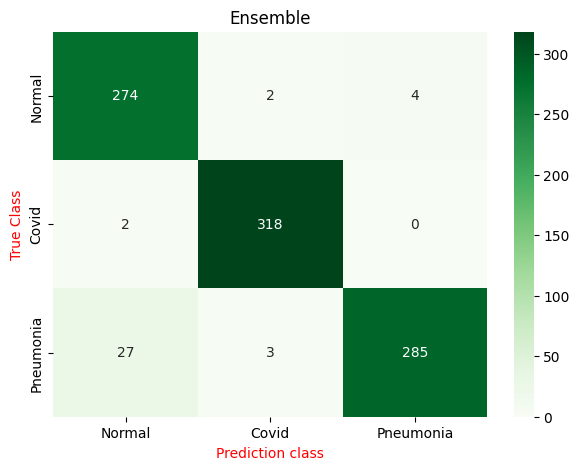

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

cf_matrix = confusion_matrix(y_true,test_value_max)

plt.figure(figsize = (7,5))
plt.title('Ensemble')
x_axis_labels = ['Normal','Covid','Pneumonia']
sns.heatmap(cf_matrix, annot=True,  fmt='g', cmap="Greens", xticklabels=x_axis_labels, yticklabels=x_axis_labels)
plt.xlabel('Prediction class', color = 'r')
plt.ylabel(ylabel='True Class', color="r")
plt.savefig('h_ensemble.png')